In [1]:
import vtk

In [2]:
from IPython.display import Image
def vtk_show(renderer, width=600, height=450):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

## Hola mundo

In [15]:
coneSource = vtk.vtkConeSource()
coneSource.SetResolution(10)

mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(coneSource.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)
 
renderer = vtk.vtkRenderer()
renderer.AddActor(actor)

renderWindow = vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)

renderWindowInteractor = vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)
 

renderWindow.Render()
renderWindowInteractor.Start()

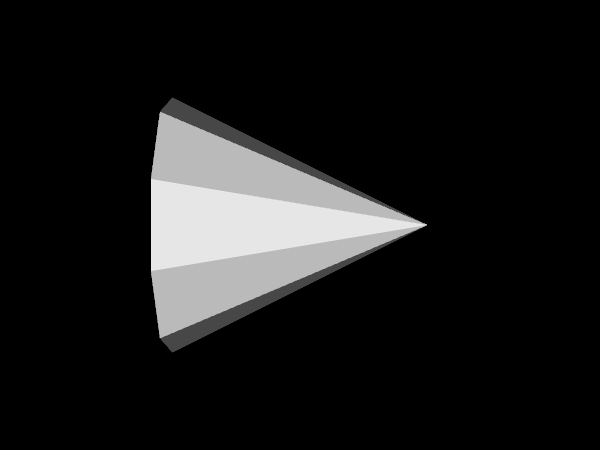

In [16]:
vtk_show(renderer)

## Ejercicio 1

![](ej01.png)

- Aumenta la resolución del cono hasta 20 caras
- Pinta el actor con SetDiffuseColor
- Rota el actor 30 grados en X, y -45 en Y
- Pon el background del renderer azul oscuro
- Aumenta el zoom de la ActiveCamera en 1.5

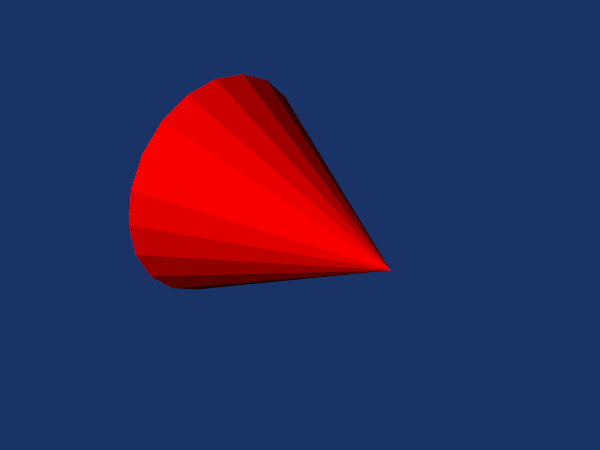

In [19]:
coneSource = vtk.vtkConeSource()
coneSource.SetResolution(20)

mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(coneSource.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)
actor.GetProperty().SetDiffuseColor(1,0,0)
actor.RotateX(30.0)
actor.RotateY(-45.0)


renderer = vtk.vtkRenderer()
renderer.SetBackground(.1, 0.2, 0.4)
renderer.AddActor(actor)

renderer.ResetCamera()
renderer.GetActiveCamera().Zoom(1.5)

vtk_show(renderer)

## Ejercicio 2

- Utiliza un Cilindro como Source
- Cambiando las propiedades de color del actor consigue una imágen como la siguiente

![](ej02.png)

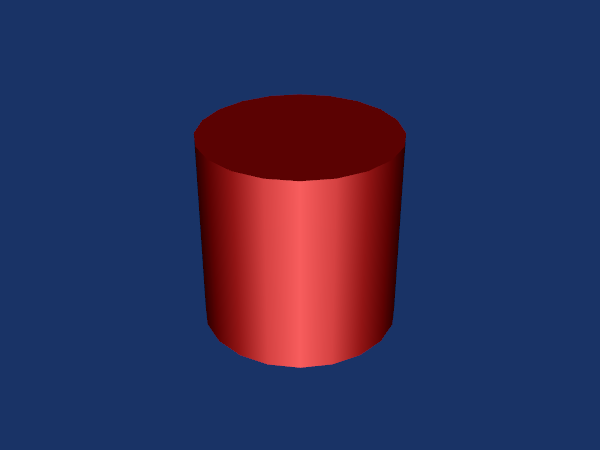

In [14]:
coneSource = vtk.vtkCylinderSource()
coneSource.SetResolution(20)

mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(coneSource.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)
actor.GetProperty().SetDiffuseColor(1,0,0)
actor.GetProperty().SetDiffuse(0.7)
actor.GetProperty().SetSpecular(1)
actor.GetProperty().SetSpecularPower(7)

actor.RotateX(30)

renderer = vtk.vtkRenderer()
renderer.SetBackground(.1, 0.2, 0.4)
renderer.AddActor(actor)

vtk_show(renderer)

## Ejercicio 3

- Cambia el estilo de interacción a 
```
vtkInteractorStyleTrackballCamera
```

- Añade un observer al interactor que escuche por 'LeftButtonPressEvent' y cambie el color del cilindro a uno aleatorio


In [6]:
from random import random

coneSource = vtk.vtkCylinderSource()
coneSource.SetResolution(20)

mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(coneSource.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)
actor.GetProperty().SetDiffuseColor(1,0,0)
actor.GetProperty().SetDiffuse(0.7)
actor.GetProperty().SetSpecular(1)
actor.GetProperty().SetSpecularPower(7)

actor.RotateX(30)

renderer = vtk.vtkRenderer()
renderer.SetBackground(.1, 0.2, 0.4)
renderer.AddActor(actor)

renderWindow = vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)

renderWindowInteractor = vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetInteractorStyle(vtk.vtkInteractorStyleTrackballCamera())
renderWindowInteractor.SetRenderWindow(renderWindow)
 
def change_color(obj, event):
    actor.GetProperty().SetDiffuseColor(random(), random(), random())
    
renderWindowInteractor.AddObserver('LeftButtonPressEvent', change_color)
    
renderWindow.Render()
renderWindowInteractor.Start()

## Ejercicio 4

![](ej04.png)

- Carga las posiciones, conexiones y radio de los átomos y píntalos todos como en la figura
- Crea un vtkPolyData y rellenalo con los datos leídos
    - SetPoints para los átomos
    - SetLines para las conexiones
    - GetPointData().SetScalars para los radios
- Combina vtkSphereSource y vtkGlyph3D para generar todas las esferas
- Colorea las esferas según su radio con vtkColorTransferFunction
- Pinta las conexiones con vtkTubeFilter
- Calcula el boundingBox con vtkOutlineFilter y píntalo junto con los demás actores


In [5]:
import vtk
import string

def readPoints(filename):
    points = vtk.vtkPoints()
    file = open(filename)

    line = file.readline()
    while line:
        data = string.split(line)
      
        if data and data[0] != '#':
            x, y, z = float(data[0]), float(data[1]), float(data[2])
            points.InsertNextPoint(x, y, z)
        line = file.readline()
    return points;
    
def readScalars(filename):
    scalars = vtk.vtkFloatArray()
    file = open(filename)

    line = file.readline()
    while line:
        data = string.split(line)
        if data and data[0] != '#':
            x= float(data[0])
            scalars.InsertNextValue(x)
        line = file.readline()
    return scalars;


def readConnections(filename):
    connections=vtk.vtkCellArray()
    file = open(filename)

    line = file.readline()
    while line:
        data = string.split(line)
        if data and data[0] != '#':
            a, b = int(data[0]), int(data[1])
            connections.InsertNextCell(2)
            connections.InsertCellPoint(a)
            connections.InsertCellPoint(b)
        line = file.readline()
    return connections


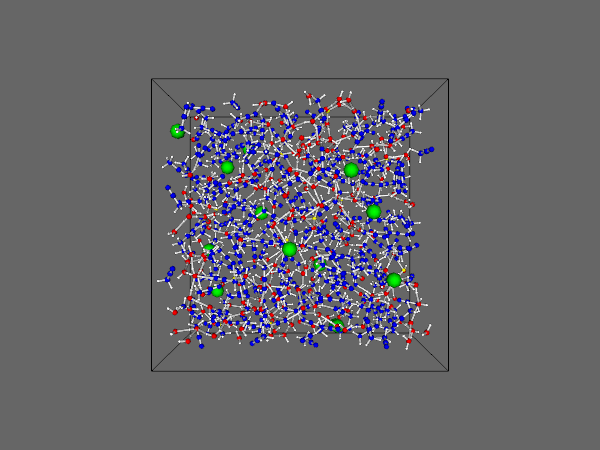

In [6]:
# Read the data into a vtkPolyData using the functions in ReadPoints.py
data = vtk.vtkPolyData()

data.SetPoints(readPoints("../../data/atoms-coordinates.txt"))
data.GetPointData().SetScalars(readScalars("../../data/atoms-radius.txt")) 
data.SetLines(readConnections("../../data/atoms-connections.txt"))

# Put spheres at each point in the dataset.
# The size and color of a sphere is determined by the
# scalar value (radius) of the corresponding point.

ball = vtk.vtkSphereSource()
ball.SetRadius(0.25)
ball.SetThetaResolution(8)
ball.SetPhiResolution(8)

ballGlyph = vtk.vtkGlyph3D()
ballGlyph.SetInputData(data)
ballGlyph.SetSourceConnection(ball.GetOutputPort())
ballGlyph.SetScaleModeToScaleByScalar()
ballGlyph.SetColorModeToColorByScalar()
ballGlyph.SetScaleFactor(2.0)

colorTransferFunction = vtk.vtkColorTransferFunction()
colorTransferFunction.AddRGBPoint(0.37, 1.0, 1.0, 1.0)
colorTransferFunction.AddRGBPoint(0.68, 1.0, 1.0, 0.0)
colorTransferFunction.AddRGBPoint(0.73, 0.0, 0.0, 1.0)
colorTransferFunction.AddRGBPoint(0.74, 1.0, 0.0, 0.0)
colorTransferFunction.AddRGBPoint(0.77, 0.0, 0.0, 1.0)
colorTransferFunction.AddRGBPoint(2.0, 0.0, 1.0, 0.0)

ballMapper = vtk.vtkPolyDataMapper()
ballMapper.SetInputConnection(ballGlyph.GetOutputPort())
ballMapper.SetLookupTable(colorTransferFunction)

ballActor = vtk.vtkActor()
ballActor.SetMapper(ballMapper)

#Create tubes between connected molecules
tubeFilter = vtk.vtkTubeFilter()
tubeFilter.SetInputData(data)
tubeFilter.SetRadius(0.15)
tubeFilter.SetNumberOfSides(7)

tubeMapper = vtk.vtkPolyDataMapper()
tubeMapper.SetInputConnection(tubeFilter.GetOutputPort())

# We want to be able to set the color ourselves!
tubeMapper.ScalarVisibilityOff() 

tubeActor = vtk.vtkActor()
tubeActor.SetMapper(tubeMapper)
tubeActor.GetProperty().SetColor(0.8,0.8,0.8)

tubeActor.GetProperty().SetSpecularColor(1, 1, 1)
tubeActor.GetProperty().SetSpecular(0.3)
tubeActor.GetProperty().SetSpecularPower(20)
tubeActor.GetProperty().SetAmbient(0.2)
tubeActor.GetProperty().SetDiffuse(0.8)

# A Bounding box
outlineData = vtk.vtkOutlineFilter()
outlineData.SetInputConnection(ballGlyph.GetOutputPort())

outlineMapper = vtk.vtkPolyDataMapper()
outlineMapper.SetInputConnection(outlineData.GetOutputPort())

outlineActor = vtk.vtkActor()
outlineActor.SetMapper(outlineMapper)
outlineActor.GetProperty().SetColor(0, 0, 0)

# Create the Renderer, Window and Interator
ren = vtk.vtkRenderer()
ren.AddActor(ballActor)
ren.AddActor(outlineActor)
ren.AddActor(tubeActor)
ren.SetBackground(0.4, 0.4, 0.4)

vtk_show(ren)

## Ejercicio 5

![](ej05.png)

- Carga el archivo Wind.vtk
- Con vtkLookupTable mapea los escalares a la saturación y fja el Hue y el Value
- Utiliza un PlaneSource colocado en un extremo del prisma como SourceConnection del vtkStreamLine
- En el PolyDataMapper utiliza los rangos que devuelve GetScalarRange() de los datos leídos
- Añade el bounding box con vtkOutlineFilter 

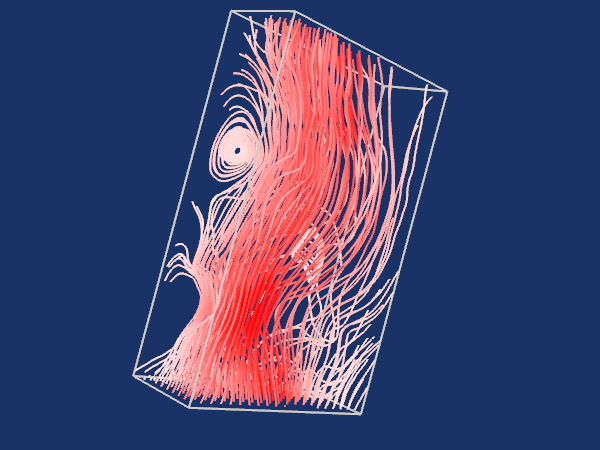

In [24]:
## import vtk
import math

reader = vtk.vtkStructuredPointsReader()
reader.SetFileName("../../data/Wind.vtk")
reader.Update()

# The range and bounds of the data
a,b = reader.GetOutput().GetScalarRange()
xmi, xma, ymi, yma, zmi, zma = reader.GetOutput().GetBounds()

# Color Transfer Function
ctf = vtk.vtkLookupTable()
ctf.SetHueRange(0.0, 0.0)
ctf.SetValueRange(1.0, 1.0)
ctf.SetSaturationRange(0.2, 1.0)
ctf.SetTableRange(a,b)

# A plane for the seeds
plane = vtk.vtkPlaneSource()
plane.SetOrigin(xmi,math.ceil(ymi),zmi)
plane.SetPoint1(xma,math.ceil(ymi),zmi)
plane.SetPoint2(xmi,math.ceil(ymi),zma)
plane.SetXResolution(20)
plane.SetYResolution(10)

# Streamlines
stream = vtk.vtkStreamLine()
stream.SetSourceConnection(plane.GetOutputPort())
stream.SetInputConnection(reader.GetOutputPort())
stream.SetIntegrationDirectionToForward()
stream.SetStepLength(0.01)

streamMapper = vtk.vtkPolyDataMapper()
streamMapper.SetLookupTable(ctf)
streamMapper.SetInputConnection(stream.GetOutputPort())
streamMapper.SetScalarRange(a,b)
streamActor = vtk.vtkActor()
streamActor.SetMapper(streamMapper)
streamActor.GetProperty().SetLineWidth(2)

# Add an outline
outline = vtk.vtkOutlineFilter()
outline.SetInputConnection(reader.GetOutputPort())

outlineMapper = vtk.vtkPolyDataMapper()
outlineMapper.SetInputConnection(outline.GetOutputPort())
outlineActor = vtk.vtkActor()

outlineActor.SetMapper(outlineMapper)
outlineActor.GetProperty().SetDiffuseColor(0.8, 0.8, 0.8)
outlineActor.GetProperty().SetLineWidth(2.0)

# Create the Renderer, Window and Interator
renderer = vtk.vtkRenderer()
renderer.SetBackground(0.1, 0.2, 0.4)
renderer.AddActor(streamActor)
renderer.AddActor(outlineActor)

renderer.ResetCamera()
renderer.GetActiveCamera().Azimuth(-45)
renderer.GetActiveCamera().Roll(-15)
renderer.ResetCameraClippingRange()

vtk_show(renderer)
